In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import PIL.Image as Image
import gym
import random

from gym import Env, spaces
import time

font = cv2.FONT_HERSHEY_COMPLEX_SMALL

In [2]:
class ChopperScape(Env):
    def __init__(self):
        super(ChopperScape, self).__init__()

        # Define a 2-D observation space
        self.observation_shape = (600, 800, 3)
        self.observation_space = spaces.Box(low=np.zeros(self.observation_shape),
                                            high=np.ones(self.observation_shape),
                                            dtype=np.float16)

        # Define an action space ranging from 0 to 4
        self.action_space = spaces.Discrete(6, )

        # Create a canvas to render the environment images upon 
        self.canvas = np.ones(self.observation_shape) * 1

        # Define elements present inside the environment
        self.elements = []

        # Maximum fuel chopper can take at once
        self.max_fuel = 1000

        # Permissible area of helicper to be 
        self.y_min = int(self.observation_shape[0] * 0.1)
        self.x_min = 0
        self.y_max = int(self.observation_shape[0] * 0.9)
        self.x_max = self.observation_shape[1]
        
    def render(self):
        # Init the canvas
        self.canvas = np.ones(self.observation_shape) * 1

        # Draw the heliopter on canvas
        for elem in self.elements:
            elem_shape = elem.icon.shape
            x, y = elem.x, elem.y
            self.canvas[y: y + elem_shape[1], x:x + elem_shape[0]] = elem.icon

        text = 'Fuel Left: {} | Rewards: {}'.format(self.fuel_left, self.ep_return)

        # Put the info on canvas
        self.canvas = cv2.putText(self.canvas, text, (10, 20), font,
                                  0.8, (0, 0, 0), 1, cv2.LINE_AA)

    def reset(self):
        # Reset the fuel consumed
        self.fuel_left = self.max_fuel

        # Reset the reward
        self.ep_return = 0

        # Number of birds
        self.bird_count = 0
        self.fuel_count = 0

        # Determine a place to intialise the chopper in
        x = random.randrange(int(self.observation_shape[0] * 0.05), int(self.observation_shape[0] * 0.10))
        y = random.randrange(int(self.observation_shape[1] * 0.15), int(self.observation_shape[1] * 0.20))

        # Intialise the chopper
        self.chopper = Chopper("chopper", self.x_max, self.x_min, self.y_max, self.y_min)
        self.chopper.set_position(x, y)

        # Intialise the elements
        self.elements = [self.chopper]

        # Reset the Canvas
        self.canvas = np.ones(self.observation_shape) * 1

        # Draw elements on the canvas
        self.render()

        # return the observation
        return self.canvas
    
    def get_action_meanings(self):
        return {0: "Right", 1: "Left", 2: "Down", 3: "Up", 4: "Do Nothing"}
    
    def has_collided(self, elem1, elem2):
        x_col = False
        y_col = False

        elem1_x, elem1_y = elem1.get_position()
        elem2_x, elem2_y = elem2.get_position()

        if 2 * abs(elem1_x - elem2_x) <= (elem1.icon_w + elem2.icon_w):
            x_col = True

        if 2 * abs(elem1_y - elem2_y) <= (elem1.icon_h + elem2.icon_h):
            y_col = True

        if x_col and y_col:
            return True

        return False
    
    def step(self, action):
        # Flag that marks the termination of an episode
        done = False

        # Assert that it is a valid action 
        assert self.action_space.contains(action), "Invalid Action"

        # Decrease the fuel counter 
        self.fuel_left -= 1 

        # Reward for executing a step.
        reward = 1      

        # apply the action to the chopper
        if action == 0:
            self.chopper.move(0,5)
        elif action == 1:
            self.chopper.move(0,-5)
        elif action == 2:
            self.chopper.move(5,0)
        elif action == 3:
            self.chopper.move(-5,0)
        elif action == 4:
            self.chopper.move(0,0)

        # Spawn a bird at the right edge with prob 0.01
        if random.random() < 0.01:

            # Spawn a bird
            spawned_bird = Bird("bird_{}".format(self.bird_count), self.x_max, self.x_min, self.y_max, self.y_min)
            self.bird_count += 1

            # Compute the x,y co-ordinates of the position from where the bird has to be spawned
            # Horizontally, the position is on the right edge and vertically, the height is randomly 
            # sampled from the set of permissible values
            bird_x = self.x_max 
            bird_y = random.randrange(self.y_min, self.y_max)
            spawned_bird.set_position(self.x_max, bird_y)

            # Append the spawned bird to the elements currently present in Env. 
            self.elements.append(spawned_bird)    

        # Spawn a fuel at the bottom edge with prob 0.01
        if random.random() < 0.01:
            # Spawn a fuel tank
            spawned_fuel = Fuel("fuel_{}".format(self.bird_count), self.x_max, self.x_min, self.y_max, self.y_min)
            self.fuel_count += 1

            # Compute the x,y co-ordinates of the position from where the fuel tank has to be spawned
            # Horizontally, the position is randomly chosen from the list of permissible values and 
            # vertically, the position is on the bottom edge
            fuel_x = random.randrange(self.x_min, self.x_max)
            fuel_y = self.y_max
            spawned_fuel.set_position(fuel_x, fuel_y)

            # Append the spawned fuel tank to the elemetns currently present in the Env.
            self.elements.append(spawned_fuel)   

        # For elements in the Ev
        for elem in self.elements:
            if isinstance(elem, Bird):
                # If the bird has reached the left edge, remove it from the Env
                if elem.get_position()[0] <= self.x_min:
                    self.elements.remove(elem)
                else:
                    # Move the bird left by 5 pts.
                    elem.move(-5,0)

                # If the bird has collided.
                if self.has_collided(self.chopper, elem):
                    # Conclude the episode and remove the chopper from the Env.
                    done = True
                    reward = -10
                    self.elements.remove(self.chopper)

            if isinstance(elem, Fuel):
                # If the fuel tank has reached the top, remove it from the Env
                if elem.get_position()[1] <= self.y_min:
                    self.elements.remove(elem)
                else:
                    # Move the Tank up by 5 pts.
                    elem.move(0, -5)

                # If the fuel tank has collided with the chopper.
                if self.has_collided(self.chopper, elem):
                    # Remove the fuel tank from the env.
                    self.elements.remove(elem)

                    # Fill the fuel tank of the chopper to full.
                    self.fuel_left = self.max_fuel

        # Increment the episodic return
        self.ep_return += 1

        # Draw elements on the canvas
        self.render()

        # If out of fuel, end the episode.
        if self.fuel_left == 0:
            done = True

        return self.canvas, reward, done, []

In [3]:
class Point(object):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        self.x = 0
        self.y = 0
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.name = name

    def set_position(self, x, y):
        self.x = self.clamp(x, self.x_min, self.x_max - self.icon_w)
        self.y = self.clamp(y, self.y_min, self.y_max - self.icon_h)

    def get_position(self):
        return (self.x, self.y)

    def move(self, del_x, del_y):
        self.x += del_x
        self.y += del_y

        self.x = self.clamp(self.x, self.x_min, self.x_max - self.icon_w)
        self.y = self.clamp(self.y, self.y_min, self.y_max - self.icon_h)

    def clamp(self, n, minn, maxn):
        return max(min(maxn, n), minn)

In [4]:
class Chopper(Point):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        super(Chopper, self).__init__(name, x_max, x_min, y_max, y_min)
        self.icon = cv2.imread("./images/chopper.jpg") / 255.0
        self.icon_w = 64
        self.icon_h = 64
        self.icon = cv2.resize(self.icon, (self.icon_h, self.icon_w))

class Bird(Point):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        super(Bird, self).__init__(name, x_max, x_min, y_max, y_min)
        self.icon = cv2.imread("./images/bird.jpg") / 255.0
        self.icon_w = 32
        self.icon_h = 32
        self.icon = cv2.resize(self.icon, (self.icon_h, self.icon_w))

class Fuel(Point):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        super(Fuel, self).__init__(name, x_max, x_min, y_max, y_min)
        self.icon = cv2.imread("./images/fuel.jpg") / 255.0
        self.icon_w = 32
        self.icon_h = 32
        self.icon = cv2.resize(self.icon, (self.icon_h, self.icon_w))

C:\Users\USER\anaconda3\lib\site-packages\gym\logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


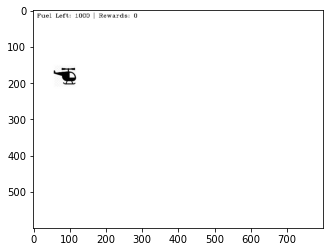

In [5]:
env = ChopperScape()
obs = env.reset()
plt.imshow(obs)

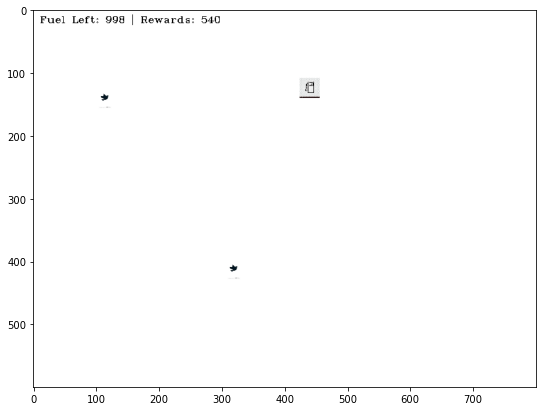

In [12]:
from IPython import display

env = ChopperScape()
obs = env.reset()

while True:
    # Take a random action
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    
    # Render the game    
#     img.set_data(obs) # just update the data
#     display.display(plt.gcf())
#     display.clear_output(wait=True)
    
    if done == True:
        break

plt.figure(figsize=(9,9))
img = plt.imshow(obs) # only call this once